In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore')

In [2]:
amzn = pd.read_csv("dataset/AMZN_2006-01-01_to_2018-01-01.csv")
googl = pd.read_csv("dataset/GOOGL_2006-01-01_to_2018-01-01.csv")
ibm = pd.read_csv("dataset/IBM_2006-01-01_to_2018-01-01.csv")
msft = pd.read_csv("dataset/MSFT_2006-01-01_to_2018-01-01.csv")
aapl = pd.read_csv("dataset/AAPL_2006-01-01_to_2018-01-01.csv")
intc = pd.read_csv("dataset/INTC_2006-01-01_to_2018-01-01.csv")
vz = pd.read_csv("dataset/VZ_2006-01-01_to_2018-01-01.csv")
amd = pd.read_csv("dataset/AMD.csv")
nvda = pd.read_csv("dataset/nvidia_all_time_daily_stock_prices.csv")
aaba = pd.read_csv("dataset/AABA_2006-01-01_to_2018-01-01.csv")

In [3]:
amd['Date'] = pd.to_datetime(amd['Date'])
nvda['Date'] = pd.to_datetime(nvda['Date'])
start_date = pd.to_datetime('2006-01-03')
end_date = pd.to_datetime('2017-12-29')
amd_crop = amd[(amd['Date'] >= start_date) & (amd['Date'] <= end_date)]
amd_crop = amd_crop.reset_index(drop=True)
amd_crop['Close'] = amd_crop['Close'].round(2)
nvda_crop = nvda[(nvda['Date'] >= start_date) & (nvda['Date'] <= end_date)]
nvda_crop = nvda_crop.reset_index(drop = True)
nvda_crop['Close'] = nvda_crop['Close'].round(2)

In [4]:
data = pd.concat([amzn[['Date','Close']], googl["Close"], msft["Close"], aapl["Close"], intc['Close'], 
                  nvda_crop['Close'], ibm["Close"], vz['Close'], aaba['Close'], amd_crop['Close']], axis = 1)
data.columns = ['Date', 'amzn', 'googl', 'msft', 'aapl', 'intc','nvda', 'ibm', 'vz', 'aaba', 'amd']
data = data.drop(data.index[-1])
data['Date'] = pd.to_datetime(data['Date'])
cols = list(data)[1:11]

train_data = data[:-90]
test_data = data[-90:]

test_data.head(5)

,Date,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
2929,2017-08-23,958.00,942.58,72.72,159.98,34.66,40.64,141.01,48.35,65.82,12.17
2930,2017-08-24,952.45,936.89,72.69,159.27,34.71,41.45,142.14,48.28,65.50,12.48
2931,2017-08-25,945.26,930.50,72.82,159.86,34.67,41.30,142.94,48.31,64.51,12.50
2932,2017-08-28,946.02,928.13,72.83,161.47,34.65,40.95,143.74,48.68,63.53,12.43
2933,2017-08-29,954.06,935.75,73.05,162.91,34.73,41.24,142.51,48.61,63.17,12.23


In [5]:
train_date = train_data['Date']
test_date = test_data['Date']
train_data = train_data[cols].astype(float)
test_data = test_data[cols].astype(float)
np.shape(train_data)

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amzn    2929 non-null   float64
 1   googl   2929 non-null   float64
 2   msft    2929 non-null   float64
 3   aapl    2929 non-null   float64
 4   intc    2929 non-null   float64
 5   nvda    2929 non-null   float64
 6   ibm     2929 non-null   float64
 7   vz      2929 non-null   float64
 8   aaba    2929 non-null   float64
 9   amd     2929 non-null   float64
dtypes: float64(10)
memory usage: 229.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 2929 to 3018
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amzn    90 non-null     float64
 1   googl   90 non-null     float64
 2   msft    90 non-null     float64
 3   aapl    90 non-null     float64
 4   intc    90 non-null     float64
 5   nvda    90 non-null     float64
 6

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc = sc.fit(train_data)
scaled_train_data = sc.transform(train_data)

In [7]:
x_train = []
y_train = []

n_future = 1
n_past = 30

for i in range(n_past, len(scaled_train_data) - n_future + 1):
    x_train.append(scaled_train_data[i - n_past:i, 0: train_data.shape[1]])
    y_train.append(scaled_train_data[i + n_future - 1 :i + n_future, 0 : train_data.shape[1]])

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
y_train.shape

(2899, 1, 10)

In [9]:
y_train[:,:,0]

array([[-0.94937324],
       [-0.94981437],
       [-0.94965396],
       ...,
       [ 2.73683489],
       [ 2.7160621 ],
       [ 2.77064081]])

In [10]:
x_train.shape

(2899, 30, 10)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [83]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation = 'tanh', return_sequences = False))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 30, 128)           71168     
                                                                 
 dropout_26 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_33 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_27 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_34 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)               

In [85]:
history_amzn = model.fit(x_train, y_train[:,:,0], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
amzn_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
amzn_pred = sc.inverse_transform(forecast_copies)[:,0]
amzn_pred

Epoch 1/5
82/82 [==============================] - 8s 95ms/step - loss: 0.0146 - val_loss: 0.1100
Epoch 2/5
82/82 [==============================] - 9s 109ms/step - loss: 0.0153 - val_loss: 0.0369
Epoch 3/5
82/82 [==============================] - 8s 97ms/step - loss: 0.0138 - val_loss: 0.0383
Epoch 4/5
82/82 [==============================] - 9s 111ms/step - loss: 0.0130 - val_loss: 0.0430
Epoch 5/5
1/1 [==============================] - 0s 95ms/step


array([938.906  , 937.6541 , 936.4894 , 934.88226, 932.97314, 931.95953,
       931.18335, 930.41785, 929.54114, 928.6785 ], dtype=float32)

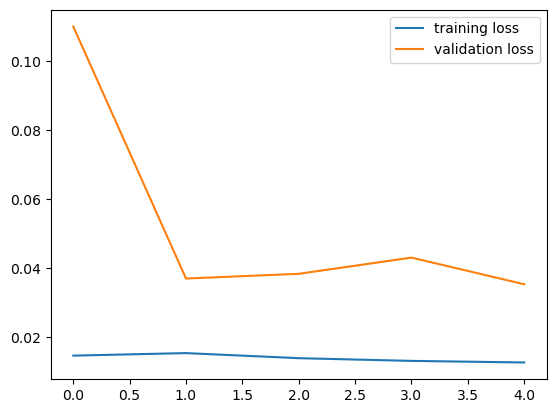

In [86]:
plt.plot(history_amzn.history['loss'], label = 'training loss')
plt.plot(history_amzn.history['val_loss'], label = 'validation loss')
plt.legend()

Text(0.5, 1.0, 'Amazon Model')

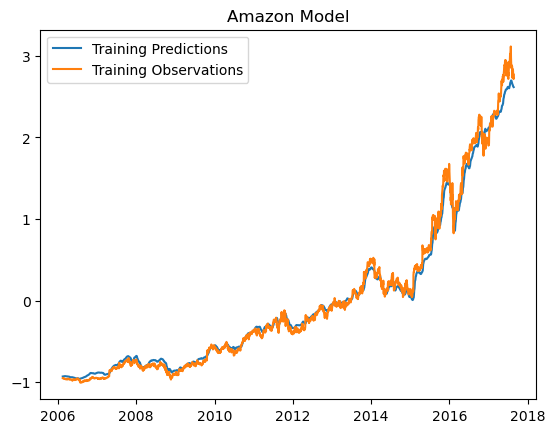

In [87]:
plt.plot(train_date[30:], amzn_predictions)
plt.plot(train_date[30:], y_train[:,:,0])
plt.legend(['Training Predictions', 'Training Observations'])
plt.title('Amazon Model')

In [91]:
history_googl = model.fit(x_train, y_train[:,:,1], epochs = 10, batch_size = 32, validation_split = 0.1, verbose = 1)
googl_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
googl_pred = sc.inverse_transform(forecast_copies)[:,0]
googl_pred

Epoch 1/10
82/82 [==============================] - 9s 108ms/step - loss: 0.0178 - val_loss: 0.3457
Epoch 2/10
82/82 [==============================] - 8s 99ms/step - loss: 0.0161 - val_loss: 0.2979
Epoch 3/10
82/82 [==============================] - 9s 112ms/step - loss: 0.0171 - val_loss: 0.1856
Epoch 4/10
82/82 [==============================] - 8s 102ms/step - loss: 0.0165 - val_loss: 0.3679
Epoch 5/10
82/82 [==============================] - 9s 104ms/step - loss: 0.0178 - val_loss: 0.3711
Epoch 6/10
82/82 [==============================] - 9s 105ms/step - loss: 0.0172 - val_loss: 0.3217
Epoch 7/10
82/82 [==============================] - 8s 98ms/step - loss: 0.0161 - val_loss: 0.7983
Epoch 8/10
82/82 [==============================] - 9s 104ms/step - loss: 0.0151 - val_loss: 0.2509
Epoch 9/10
82/82 [==============================] - 8s 96ms/step - loss: 0.0158 - val_loss: 0.2984
Epoch 10/10
1/1 [==============================] - 0s 50ms/step


array([692.7248 , 692.5705 , 692.1368 , 691.3774 , 690.696  , 691.14154,
       691.8987 , 692.0022 , 691.53064, 690.6788 ], dtype=float32)

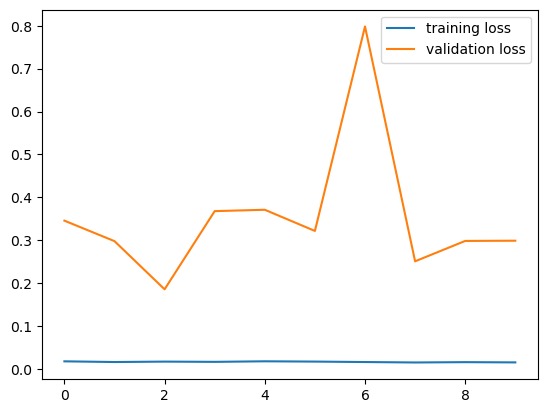

In [92]:
plt.plot(history_googl.history['loss'], label = 'training loss')
plt.plot(history_googl.history['val_loss'], label = 'validation loss')
plt.legend()

Text(0.5, 1.0, 'Google Model')

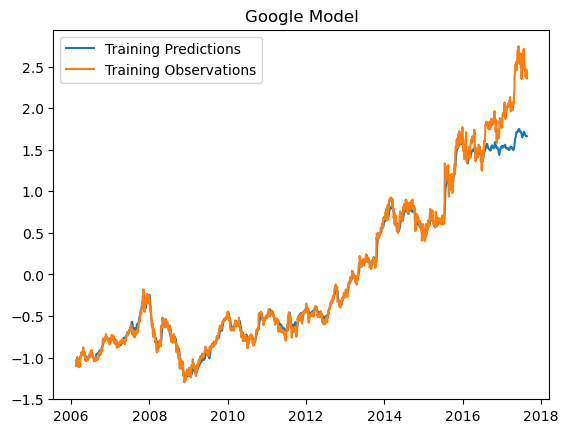

In [93]:
plt.plot(train_date[30:], googl_predictions)
plt.plot(train_date[30:], y_train[:,:,1])
plt.legend(['Training Predictions', 'Training Observations'])
plt.title('Google Model')

In [94]:
history_msft = model.fit(x_train, y_train[:,:,2], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
msft_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
msft_pred = sc.inverse_transform(forecast_copies)[:,0]
msft_pred

Epoch 1/5
82/82 [==============================] - 9s 106ms/step - loss: 0.0295 - val_loss: 0.9165
Epoch 2/5
82/82 [==============================] - 8s 96ms/step - loss: 0.0209 - val_loss: 0.6474
Epoch 3/5
82/82 [==============================] - 9s 105ms/step - loss: 0.0176 - val_loss: 0.4804
Epoch 4/5
82/82 [==============================] - 8s 97ms/step - loss: 0.0173 - val_loss: 0.5841
Epoch 5/5
1/1 [==============================] - 0s 59ms/step


array([668.94226, 669.3915 , 669.00397, 668.1983 , 668.03064, 669.48425,
       671.2087 , 671.7918 , 671.5656 , 670.925  ], dtype=float32)

In [95]:
history_aapl = model.fit(x_train, y_train[:,:,3], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
aapl_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
aapl_pred = sc.inverse_transform(forecast_copies)[:,0]
aapl_pred

Epoch 1/5
82/82 [==============================] - 7s 90ms/step - loss: 0.0432 - val_loss: 0.4540
Epoch 2/5
82/82 [==============================] - 9s 105ms/step - loss: 0.0210 - val_loss: 0.5013
Epoch 3/5
82/82 [==============================] - 8s 99ms/step - loss: 0.0226 - val_loss: 0.2312
Epoch 4/5
82/82 [==============================] - 9s 107ms/step - loss: 0.0200 - val_loss: 0.2149
Epoch 5/5
1/1 [==============================] - 0s 61ms/step


array([588.4691 , 596.58923, 602.4732 , 607.27795, 612.35236, 618.4774 ,
       623.28595, 625.2735 , 625.1671 , 624.1348 ], dtype=float32)

In [96]:
history_intc = model.fit(x_train, y_train[:,:,4], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
intc_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
intc_pred = sc.inverse_transform(forecast_copies)[:,0]
intc_pred

Epoch 1/5
82/82 [==============================] - 8s 99ms/step - loss: 0.0639 - val_loss: 0.2089
Epoch 2/5
82/82 [==============================] - 9s 104ms/step - loss: 0.0325 - val_loss: 0.1023
Epoch 3/5
82/82 [==============================] - 8s 100ms/step - loss: 0.0290 - val_loss: 0.1360
Epoch 4/5
82/82 [==============================] - 9s 107ms/step - loss: 0.0308 - val_loss: 0.2834
Epoch 5/5
1/1 [==============================] - 0s 57ms/step


array([578.3344 , 578.57983, 573.2196 , 563.46906, 554.7703 , 550.1653 ,
       547.87665, 543.52075, 537.9831 , 532.01306], dtype=float32)

In [97]:
history_nvda = model.fit(x_train, y_train[:,:,5], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
nvda_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
nvda_pred = sc.inverse_transform(forecast_copies)[:,0]
nvda_pred

Epoch 1/5
82/82 [==============================] - 8s 99ms/step - loss: 0.0376 - val_loss: 4.7355
Epoch 2/5
82/82 [==============================] - 9s 108ms/step - loss: 0.0061 - val_loss: 4.7175
Epoch 3/5
82/82 [==============================] - 8s 96ms/step - loss: 0.0046 - val_loss: 4.5749
Epoch 4/5
82/82 [==============================] - 9s 109ms/step - loss: 0.0039 - val_loss: 4.5621
Epoch 5/5
1/1 [==============================] - 0s 61ms/step


array([510.48254, 510.6413 , 510.65488, 510.7933 , 510.96188, 510.901  ,
       510.97052, 511.02753, 511.0459 , 511.01654], dtype=float32)

In [98]:
history_ibm = model.fit(x_train, y_train[:,:,6], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
ibm_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
ibm_pred = sc.inverse_transform(forecast_copies)[:,0]
ibm_pred

Epoch 1/5
82/82 [==============================] - 8s 98ms/step - loss: 0.1741 - val_loss: 0.1053
Epoch 2/5
82/82 [==============================] - 9s 108ms/step - loss: 0.0409 - val_loss: 0.1696
Epoch 3/5
82/82 [==============================] - 8s 98ms/step - loss: 0.0358 - val_loss: 0.1737
Epoch 4/5
82/82 [==============================] - 9s 107ms/step - loss: 0.0322 - val_loss: 0.1755
Epoch 5/5
1/1 [==============================] - 0s 62ms/step


array([562.96356, 564.1039 , 564.2303 , 562.731  , 558.25824, 554.70593,
       551.4494 , 547.86505, 543.6381 , 540.5778 ], dtype=float32)

In [99]:
history_vz = model.fit(x_train, y_train[:,:,7], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
vz_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
vz_pred = sc.inverse_transform(forecast_copies)[:,0]
vz_pred

Epoch 1/5
82/82 [==============================] - 8s 98ms/step - loss: 0.1395 - val_loss: 0.1682
Epoch 2/5
82/82 [==============================] - 8s 104ms/step - loss: 0.0486 - val_loss: 0.2957
Epoch 3/5
82/82 [==============================] - 8s 97ms/step - loss: 0.0368 - val_loss: 0.1274
Epoch 4/5
82/82 [==============================] - 9s 107ms/step - loss: 0.0320 - val_loss: 0.1778
Epoch 5/5
1/1 [==============================] - 0s 58ms/step


array([649.58325, 653.03076, 655.2412 , 656.2615 , 655.7847 , 656.33954,
       656.7605 , 656.8652 , 656.5972 , 656.0105 ], dtype=float32)

In [100]:
history_aaba = model.fit(x_train, y_train[:,:,8], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
aaba_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
aaba_pred = sc.inverse_transform(forecast_copies)[:,0]
aaba_pred

Epoch 1/5
82/82 [==============================] - 8s 100ms/step - loss: 0.0859 - val_loss: 0.3866
Epoch 2/5
82/82 [==============================] - 8s 102ms/step - loss: 0.0283 - val_loss: 0.2099
Epoch 3/5
82/82 [==============================] - 8s 98ms/step - loss: 0.0270 - val_loss: 0.2818
Epoch 4/5
82/82 [==============================] - 9s 107ms/step - loss: 0.0257 - val_loss: 0.2503
Epoch 5/5
1/1 [==============================] - 0s 67ms/step


array([724.68634, 727.483  , 728.7322 , 728.0524 , 726.2005 , 726.82745,
       729.0639 , 732.1729 , 735.77075, 739.843  ], dtype=float32)

In [101]:
history_amd = model.fit(x_train, y_train[:,:,9], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)
amd_predictions = model.predict(x_train).flatten()
n_future = 10
forecast = model.predict(x_train[-n_future:])
forecast_copies = np.repeat(forecast, train_data.shape[1], axis = -1)
amd_pred = sc.inverse_transform(forecast_copies)[:,0]
amd_pred

Epoch 1/5
82/82 [==============================] - 8s 102ms/step - loss: 0.1454 - val_loss: 0.5335
Epoch 2/5
82/82 [==============================] - 8s 103ms/step - loss: 0.0516 - val_loss: 0.1183
Epoch 3/5
82/82 [==============================] - 8s 94ms/step - loss: 0.0343 - val_loss: 0.3319
Epoch 4/5
82/82 [==============================] - 9s 105ms/step - loss: 0.0400 - val_loss: 0.1842
Epoch 5/5
1/1 [==============================] - 0s 76ms/step


array([517.31726, 510.54358, 501.56796, 484.9797 , 463.9646 , 446.3275 ,
       432.2542 , 423.81985, 420.54086, 421.5649 ], dtype=float32)

In [102]:
Predicted_Values = pd.DataFrame({
    'amzn': amzn_pred,
    'googl': googl_pred, 
    'msft': msft_pred, 
    'aapl': aapl_pred, 
    'intc': intc_pred,
    'nvda': nvda_pred, 
    'ibm': ibm_pred, 
    'vz': vz_pred, 
    'aaba': aaba_pred, 
    'amd' : amd_pred
})
Predicted_Values = Predicted_Values.astype(float).round(2)

In [103]:
Predicted_Values

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
0,938.91,692.72,668.94,588.47,578.33,510.48,562.96,649.58,724.69,517.32
1,937.65,692.57,669.39,596.59,578.58,510.64,564.10,653.03,727.48,510.54
2,936.49,692.14,669.00,602.47,573.22,510.65,564.23,655.24,728.73,501.57
3,934.88,691.38,668.20,607.28,563.47,510.79,562.73,656.26,728.05,484.98
4,932.97,690.70,668.03,612.35,554.77,510.96,558.26,655.78,726.20,463.96
5,931.96,691.14,669.48,618.48,550.17,510.90,554.71,656.34,726.83,446.33
6,931.18,691.90,671.21,623.29,547.88,510.97,551.45,656.76,729.06,432.25
7,930.42,692.00,671.79,625.27,543.52,511.03,547.87,656.87,732.17,423.82
8,929.54,691.53,671.57,625.17,537.98,511.05,543.64,656.60,735.77,420.54
9,928.68,690.68,670.92,624.13,532.01,511.02,540.58,656.01,739.84,421.56


In [104]:
train_data[-n_future:]

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
2919,982.01,940.08,72.47,161.06,36.59,42.58,142.11,48.60,59.77,13.11
2920,956.92,923.59,71.41,155.32,36.14,43.03,141.77,48.22,58.03,12.83
2921,967.99,930.09,72.50,157.48,35.87,41.19,141.84,48.02,57.92,12.12
2922,983.30,938.93,73.59,159.85,36.34,38.99,141.84,48.06,58.87,12.23
2923,982.74,938.08,73.22,161.60,36.00,42.10,142.32,48.78,59.99,12.76
2924,978.18,944.27,73.65,160.95,35.81,41.74,142.07,48.48,60.65,13.02
2925,960.57,927.66,72.40,157.86,35.17,41.29,142.50,48.41,62.20,12.63
2926,958.47,926.18,72.49,157.50,35.01,40.37,140.70,47.89,63.07,12.34
2927,953.29,920.87,72.15,157.21,34.92,40.38,139.70,47.69,63.60,12.37
2928,966.90,940.40,73.16,159.78,34.65,39.79,140.33,48.14,65.42,12.05


In [105]:
from sklearn.metrics import mean_squared_error
mse_per_column = {}
for col in train_data.columns:
    mse_per_column[col] = mean_squared_error(train_data[-n_future:][col], Predicted_Values[col])
mse_per_column

{'amzn': 1385.44361,
 'googl': 58311.00403,
 'msft': 356589.74285,
 'aapl': 205815.88313,
 'intc': 270991.3260499999,
 'nvda': 220622.63587000003,
 'ibm': 171071.20063,
 'vz': 368476.19324000005,
 'aaba': 447475.33087999996,
 'amd': 203603.37531}

In [145]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 11
n_days_for_prediction=10  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_date)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(x_train[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = sc.inverse_transform(prediction_copies)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


[Timestamp('2017-08-08 00:00:00'), Timestamp('2017-08-09 00:00:00'), Timestamp('2017-08-10 00:00:00'), Timestamp('2017-08-11 00:00:00'), Timestamp('2017-08-14 00:00:00'), Timestamp('2017-08-15 00:00:00'), Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-17 00:00:00'), Timestamp('2017-08-18 00:00:00'), Timestamp('2017-08-21 00:00:00')]
1/1 [==============================] - 0s 21ms/step
